# Text classification

Example of a many-to-one problem using recurrent neural network. Following this [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

Let's try just like that.

Required tasks:

- load data
- vectorize using one-hot encoding
- write network class
- setup training
- train

Next: 
- Find how to use a dataloader for inputs of varying size

In [398]:
# imports
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import pandas
import glob
import re
import string
import unicodedata
import matplotlib.pyplot as plt
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s, vocabulary):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in vocabulary
    )

# Preprocessing
## Create dictionaries that map language->name and name->language

In [201]:
file_list = glob.glob("./Data/names/names/*")
languages = [re.findall(r'./Data/names/names/(.*)\.txt',t)[0] for t in file_list]
lang2name = {}
name2lang = {}
# vocabulary = string.ascii_letters + " .,;-'"
vocabulary = string.ascii_lowercase + " .,;'"

max_seq_length = 0
for lang, filename in zip(languages,file_list):
    with open(filename) as file:
        names = [l[:-1] for l in file.readlines()]
        lang2name[lang] = names
        for n in names:
            name2lang[unicode_to_ascii(n, vocabulary)] = lang
            max_seq_length = max(max_seq_length,len(n))

In [389]:
# len()for key in lang2name.keys()
total_names = 0
lang2weights = {}
for k, v in lang2name.items():
    print(k, len(v))
    total_names += len(v)
    lang2weights[k] = 1.0/(len(v)**(1.0/1.5))
print(total_names)
for k, v in lang2weights.items():
    lang2weights[k] *= 100#total_names
#     lang2weights[k] = 1.0/lang2weights[k]
lang2weights

Czech 519
German 724
Arabic 2000
Japanese 991
Chinese 268
Vietnamese 73
Russian 9408
French 277
Irish 232
English 3668
Spanish 298
Greek 203
Italian 709
Portuguese 74
Scottish 100
Dutch 297
Korean 94
Polish 139
20074


{'Czech': 1.5484187731571761,
 'German': 1.2402453931395274,
 'Arabic': 0.6299605249474367,
 'Japanese': 1.006045362995162,
 'Chinese': 2.4057110922637746,
 'Vietnamese': 5.725122186823606,
 'Russian': 0.22438911938367678,
 'French': 2.353315492842517,
 'Irish': 2.6485489876602135,
 'English': 0.42044944350974206,
 'Spanish': 2.241416117999791,
 'Greek': 2.8951382557688383,
 'Italian': 1.2576771673710465,
 'Portuguese': 5.673427640281633,
 'Scottish': 4.64158883361278,
 'Dutch': 2.2464445359286023,
 'Korean': 4.837059514655685,
 'Polish': 3.7266917031512907}

# Dataset class

In [390]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, seq2cat, vocabulary, categories, max_seq_length):
        # seq2cat (dict) mapping input sequence and output category
        super(MyDataset,self).__init__()
        self.input_sequences = list(seq2cat.keys())
        self.output_category =  list(seq2cat.values())
        self.categories = categories
        self.vocabulary = vocabulary
        self.max_seq_length = max_seq_length
        
        self.vocab_length = len(self.vocabulary)
        self.vocab2vec = {}
        for i, vocab in enumerate(self.vocabulary):
            self.vocab2vec[vocab] = torch.zeros((1,self.vocab_length),dtype=torch.float32)
            self.vocab2vec[vocab][0,i] = 1
            
        num_categories = len(categories)
        self.cat2vec = {}
        for i, cat in enumerate(categories):
            self.cat2vec[cat] = torch.tensor(i,dtype=torch.long)
            
            
        
    def __len__(self):
        return len(self.input_sequences)
    
    def _get_seq_vec(self,sequence):
        out = torch.zeros((self.max_seq_length,self.vocab_length))
        for i, vec in enumerate(sequence.lower()):
            out[i,:] = self.vocab2vec[vec]
        return out
#         return torch.cat([self.vocab2vec[vec] for vec in sequence.lower()],axis=0)
        
    
    
    def __getitem__(self, index):
#         print(self.input_sequences[index])
        input_sequence = self._get_seq_vec(self.input_sequences[index])
        output_category = self.cat2vec[self.output_category[index]]
        
#         print(input_sequence)
#         print(output_category.shape)
        
        return (input_sequence, output_category)
    
# Test    
dataset = MyDataset(name2lang, vocabulary, languages, max_seq_length)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True)
inp, cat = next(iter(dataloader))
cat.shape

torch.Size([1])

# Define neural network

In [391]:
class MyRNN(nn.Module):
    def __init__(self,vocab_length, num_categories,num_layers=1):
        super(MyRNN,self).__init__()
        self.rnn = nn.RNN(input_size=vocab_length,
                     hidden_size=num_categories,
                     num_layers=num_layers, batch_first=True)
#         self.rnn = nn.LSTM(input_size=vocab_length,
#                      hidden_size=num_categories,
#                      num_layers=1, batch_first=True)
#         self.linear = nn.Linear()
    def forward(self,X):
        return self.rnn(X)

# Initialize training

In [423]:
num_categories = len(languages)
vocab_length = len(vocabulary)
model = MyRNN(vocab_length, num_categories,1)
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
dataset = MyDataset(name2lang, vocabulary, languages, max_seq_length)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=64, shuffle=True)
inp, cat = next(iter(dataloader))
# inp.shape
# cat.shape


# Train

In [425]:
# optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
for epoch in range(10):
    n_data = len(dataloader)
    loss_total = 0
    accuracy = 0
    for i, (inp, ground_truth) in enumerate(dataloader):
#         x_packed = pack_padded_sequence(x_embed, x_lens, batch_first=True, enforce_sorted=False)
        seq_len = inp.sum(dim=2).sum(dim=1).int()
        inp = torch.nn.utils.rnn.pack_padded_sequence(inp,seq_len,batch_first=True, enforce_sorted=False)

        optimizer.zero_grad()
        cat_out, h_out = model(inp)
        cat_out, out_len = torch.nn.utils.rnn.pad_packed_sequence(cat_out, batch_first=True)

        out = torch.cat([cat_out[sample,out_len[sample]-1,:].unsqueeze(0) for sample in range(cat_out.shape[0])],dim=0)

        loss = loss_fn(out, ground_truth)
#         with torch.no_grad():
        loss_total += loss.mean()
#         loss *= torch.tensor([lang2weights[languages[gt]] for gt in ground_truth])
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
#             pred = np.argmax(cat_out[:,-1,:],axis=1)
            pred = np.argmax(out,axis=1)
            accuracy += (pred == ground_truth).sum()/len(ground_truth)
        
#         loss_total += loss
    loss_total /= len(dataloader)
    accuracy /= len(dataloader)
    print(f"epoch {epoch:03d}: loss={loss_total:.2e}, accuracy={accuracy:.2e}")

epoch 000: loss=1.65e+00, accuracy=5.63e-01
epoch 001: loss=1.65e+00, accuracy=5.75e-01
epoch 002: loss=1.65e+00, accuracy=5.88e-01
epoch 003: loss=1.65e+00, accuracy=6.13e-01
epoch 004: loss=1.65e+00, accuracy=6.66e-01
epoch 005: loss=1.64e+00, accuracy=6.75e-01
epoch 006: loss=1.64e+00, accuracy=6.83e-01
epoch 007: loss=1.64e+00, accuracy=6.89e-01
epoch 008: loss=1.63e+00, accuracy=6.94e-01
epoch 009: loss=1.63e+00, accuracy=6.97e-01


# Confusion matrix

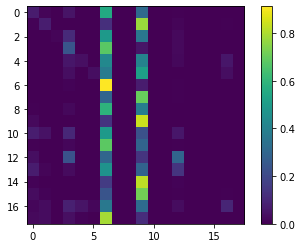

In [426]:
conf_mat = np.zeros((len(languages),len(languages)))
for i, (inp, ground_truth) in enumerate(dataloader):
        seq_len = inp.sum(dim=2).sum(dim=1).int()
        inp = torch.nn.utils.rnn.pack_padded_sequence(inp,seq_len,batch_first=True, enforce_sorted=False)
        cat_out, h_out = model(inp)
        cat_out, out_len = torch.nn.utils.rnn.pad_packed_sequence(cat_out, batch_first=True)
        out = torch.cat([cat_out[sample,out_len[sample]-1,:].unsqueeze(0) for sample in range(cat_out.shape[0])],dim=0)
        with torch.no_grad():
            pred = np.argmax(out,axis=1)
            for p, gt in zip(pred, ground_truth):
                conf_mat[gt,p] += 1.0
#             accuracy += (pred == ground_truth).sum()/len(ground_truth)
for i, l in enumerate(languages):
    conf_mat[i,:] /= np.sum(conf_mat[i,:])#len(lang2name[l])
    plt.imshow(conf_mat)      
plt.colorbar()

So far it is just guessing English or Russian (the two most common classes for everything)